# Use of EXIOBASE3.8
We will illustrate here the use of EXIOBASE by calculating EU GHG emissions from different perspectives.

Note: there is a bit of experimentation going on, for example the regionalization of the stressor matrix.

In [3]:
# Let's get comfortable first
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [4]:
import pymrio as mr
import pandas as pd
import numpy as np
from scipy.linalg import block_diag
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

Import the data. You'll need to have downloaded EXIOBASE 3.8 files from https://zenodo.org/record/4277368 into `EXIOBASE_PATH`.
I recommend using the command described below.
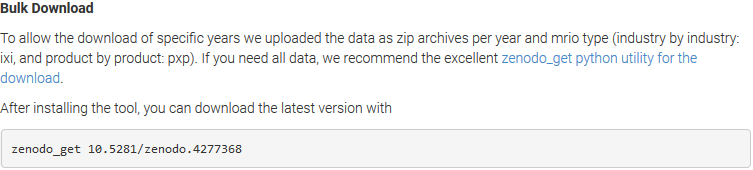

Then specify a year you want to work with. Note: in the 3.8 version, year 2019 has some issues, specifically for EU and Denmark in particular. You may want to choose another year instead.

In [6]:
year = 2018
EXIOBASE_PATH = '../exiobase/IOT_{}_pxp.zip'.format(year)

Then, just import the IO system with `pymrio`:

In [7]:
io = mr.parse_exiobase3(path=EXIOBASE_PATH)

Run the various calculations (satellite factors, footprint reports, ...)

In [8]:
io.calc_all()

EXIOBASE does not come bundled with a characterization matrix, it will only give you raw emission data. To calculate greenhouse gas emissions values in GWP100, you need to set up a characterization matrix yourself. Let's use the UNFCCC scope for emissions (I think it's correct, but may not, for example LULUCF emissions are not included). I am using the IPCC AR5 factors here, over 100 years.

In [9]:
GWP100_unfccc=pd.Series(
[1,1,1,
34,34, #34,34,34,34,34,34,34,34,
298,298],
index=
['CO2 - combustion - air',
 'CO2 - non combustion - Cement production - air',
 'CO2 - non combustion - Lime production - air',
 'CH4 - combustion - air',
#  'CH4 - non combustion - Extraction/production of (natural) gas - air',
#  'CH4 - non combustion - Extraction/production of crude oil - air',
#  'CH4 - non combustion - Mining of antracite - air',
#  'CH4 - non combustion - Mining of bituminous coal - air',
#  'CH4 - non combustion - Mining of coking coal - air',
#  'CH4 - non combustion - Mining of lignite (brown coal) - air',
#  'CH4 - non combustion - Mining of sub-bituminous coal - air',
#  'CH4 - non combustion - Oil refinery - air',
 'CH4 - agriculture - air',
 'N2O - combustion - air',
 'N2O - agriculture - air']
)

GWP100_unfccc

CO2 - combustion - air                              1
CO2 - non combustion - Cement production - air      1
CO2 - non combustion - Lime production - air        1
CH4 - combustion - air                             34
CH4 - agriculture - air                            34
N2O - combustion - air                            298
N2O - agriculture - air                           298
dtype: int64

Now we prepare the data for plotting.

In [11]:
sns.set(font_scale=1)

n_sectors   = 163
n_sectors_Y = 7

method = GWP100_unfccc # in case you set up other method vectors

# create the GHG factors in GWP100 
S_GWP   = method.dot(io.satellite.S.loc[method.index])
F_GWP_Y = method.dot(io.satellite.F_Y.loc[method.index])

# and calculate the greenhouse gas emissions per sector of consumption for the intermediate consumption
GHG_cons_total = io.L.multiply(S_GWP,axis=0).dot(io.Y)

# group by region (we don't want sector resolution) and convert to Mt
GHG_cons_to_plot = GHG_cons_total.groupby('region',
                                    axis=1).sum().groupby('region',
                                                           axis=0).sum().reindex(io.get_regions(),
                                                                                 axis=0).reindex(io.get_regions(),
                                                                                                 axis=1)*1e-9

# same, for the emissions of final demand
GHG_cons_Y = pd.DataFrame(block_diag(*[F_GWP_Y.iloc[i*n_sectors_Y:(i+1)*n_sectors_Y] for i in range(49)]),
            index   = io.get_regions(),
            columns = io.Y.columns)
GHG_cons_Y_to_plot = GHG_cons_Y.groupby('region',axis=1).sum().reindex(io.get_regions(), axis=1)*1e-9

# sum them both
GHG_cons = GHG_cons_to_plot + GHG_cons_Y_to_plot

# and create column and row for production-based emissions and consumption-based emissions 
GHG_cons['EMBODIED IN\nPRODUCTION'] = GHG_cons.sum(1)
GHG_cons.loc['EMBODIED IN\nCONSUMPTION'] = GHG_cons.sum()

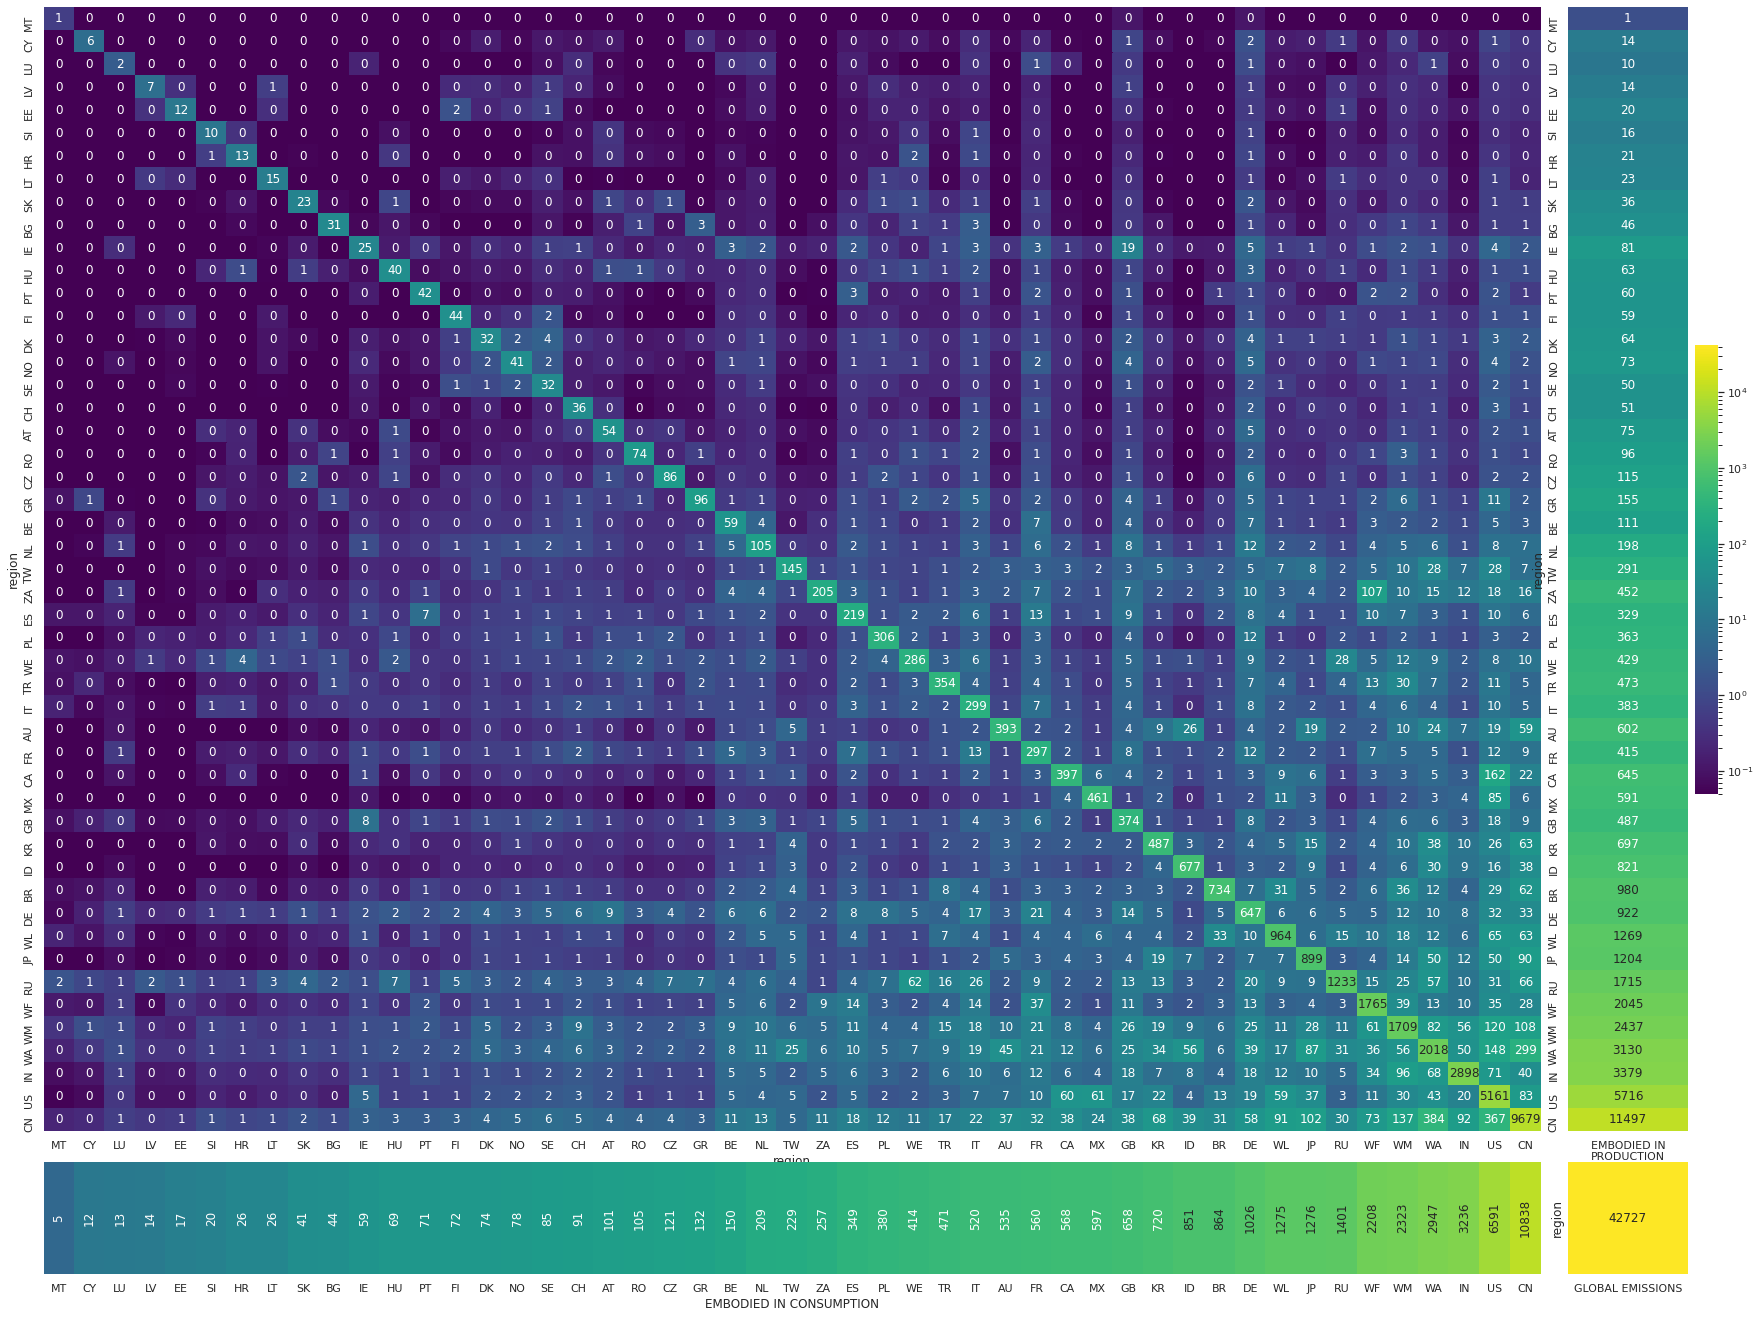

In [12]:
max_r = 49 # EU = 28, All = 49
cmap  = 'viridis'

GHG_cons_cutoff=GHG_cons.drop(GHG_cons.index[max_r:-1],axis=0).drop(GHG_cons.columns[max_r:-1],axis=1)

GHG_cons_sorted=GHG_cons_cutoff.sort_values(by='EMBODIED IN\nCONSUMPTION', axis=1)
GHG_cons_sorted=GHG_cons_sorted.reindex([*GHG_cons_sorted.columns[:-1],'EMBODIED IN\nCONSUMPTION'], axis=0)

fig, ax = plt.subplots(ncols=2,
                       nrows=2,
                       figsize=(30, 20),
                       subplot_kw={'facecolor':'w'},
                       gridspec_kw={'width_ratios': [10, 1],
                                    'height_ratios': [10, 1],
                                    'wspace': 2/3*0.05,
                                    'hspace': 0.05,
                                    'bottom': 0})

sns.heatmap(GHG_cons_sorted.iloc[:max_r,:max_r], annot=True,
            norm=matplotlib.colors.LogNorm(vmin=.05,
                                           vmax=GHG_cons.max().max()),
            cbar=False,
            cmap=cmap,
           fmt='.0f',
           ax=ax[0,0])
sns.heatmap(GHG_cons_sorted[GHG_cons.columns[-1:]].iloc[:max_r,:max_r], annot=True,
            norm=matplotlib.colors.LogNorm(vmin=.05,
                                           vmax=GHG_cons.max().max()),
            
            cmap=cmap,
           fmt='.0f',
           ax=ax[0,1])
sns.heatmap(GHG_cons_sorted.loc[GHG_cons.index[-1:]].iloc[:max_r,:max_r], annot=True,
            annot_kws={'rotation': 90},
            norm=matplotlib.colors.LogNorm(vmin=.05,
                                           vmax=GHG_cons.max().max()),
            cbar=False,
            cmap=cmap,
           fmt='.0f',
           ax=ax[1,0])
sns.heatmap(GHG_cons_sorted.loc[GHG_cons.index[-1:],GHG_cons.columns[-1:]].iloc[:max_r,:max_r], annot=True,
            norm=matplotlib.colors.LogNorm(vmin=.05,
                                           vmax=GHG_cons.max().max()),
            cbar=False,
            cmap=cmap,
            yticklabels=[],
            xticklabels=['GLOBAL EMISSIONS'],
           fmt='.0f',
           ax=ax[1,1])

ax[1,1].set_xlabel('')
ax[1,0].set_xlabel('EMBODIED IN CONSUMPTION')
ax[1,0].set_ylabel('')
ax[1,0].set_yticklabels([])

# resize the corner box
ax01pos = ax[0,1].get_position().bounds
ax11pos = list(ax[1,1].get_position().bounds)
ax11pos[2] = ax01pos[2]
ax[1,1].set_position(ax11pos)

fig.savefig('GHG_in_trade_{}.png'.format(year),
            facecolor='white',
            edgecolor='none')